## C-M ratio implementation ##


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa

import glob

import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd

# import our own small lib. I access this one through PyCharm
import nsidc

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


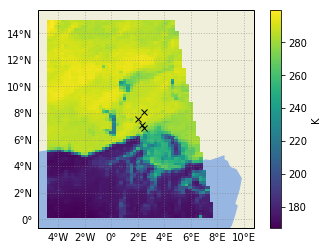

In [3]:
# ds = xr.open_dataset(fn_out)
# The following dataset satellite images of a certain region with specific settings (37GHz band, Horizontal Polarization, Ascending recording )
ds = xr.open_dataset('C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2002.nc')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
# get a mesh of the coordinates in grid's projection
xi, yi = np.meshgrid(ds.x, ds.y)

# the chosen projection is not (yet) supported by caropy.crs, so we need to do the transformation ourselves for now. 
# No biggy, here we go

# define the proj4string belonging to the grids you are downloading. You can find these in a downloaded sample 
# under the variable/attribute crs.proj4text. Here we simply copy-paste that.
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)
# now drape the data on the map
p = ax.pcolormesh(loni, lati, ds['TB'][1].values, transform=ccrs.PlateCarree())


# also plot some points of interest 
points_interest = [(2.4406387000000223, 6.893251099999999),
                   (2.2999999999999545, 7.099999999999999),
                   (2.4851462999999967, 8.0335995),
                   (2.0499999999999545, 7.566667)
]
ax = plt.axes(projection=ccrs.PlateCarree())
ax = nsidc.plot_points(ax, points_interest, marker='x', color='k', linewidth=0., transform=ccrs.PlateCarree())
plt.colorbar(p, label='K')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Gracefully close ds
ds.close()

We assume there is a dataset available to work with (downloaded with NSIDC_Measures.ipynb). If you have retrieved a complete dataset over multiple years, please continue with the following part. We will:
- extract a time series of brightness temperatures over a river section
- extract time series in the surroundings of river section.
- apply the C/M ratio method (see Brakenridge et al., 2007, http://onlinelibrary.wiley.com/doi/10.1029/2006WR005238/full

We start by defining gauging points of interest, and transform these into the projection system of the Measures grids.

In [4]:
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'

# # Ouémé:
# points_interest = [(2.4406387000000223, 6.893251099999999),
#                    (2.2999999999999545, 7.099999999999999),
#                    (2.4851462999999967, 8.0335995),
#                    (2.0499999999999545, 7.566667)
# ]

# # Ouémé delta
# points_interest = [(2.28, 6.43),
#                    (2.38, 6.43),
#                    (2.48, 6.43),
#                    (2.58, 6.43),
#                    (2.28, 6.53),
#                    (2.38, 6.53),
#                    (2.48, 6.53),
#                    (2.58, 6.53),
#                    (2.28, 6.63),
#                    (2.38, 6.63),
#                    (2.48, 6.63),
#                    (2.58, 6.63),
#                    (2.28, 6.73),
#                    (2.38, 6.73),
#                    (2.48, 6.73),
#                    (2.58, 6.73),
#                    (2.28, 6.83),
#                    (2.38, 6.83),
#                    (2.48, 6.83),
#                    (2.58, 6.83),
#                    (2.44, 6.89)
# ]

# Ouémé delta
points_interest = [(2.43, 6.43), #wet calibration
                   (2.25, 6.57), #dry calibration
                   (2.43, 6.55)  #measurement cell
]
                   

# #Niger:
# points_interest = [(-6.565704345703125, 13.366907166629518),
#                    (-2.8667449951171875, 16.678293098288513),
# ]

# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)


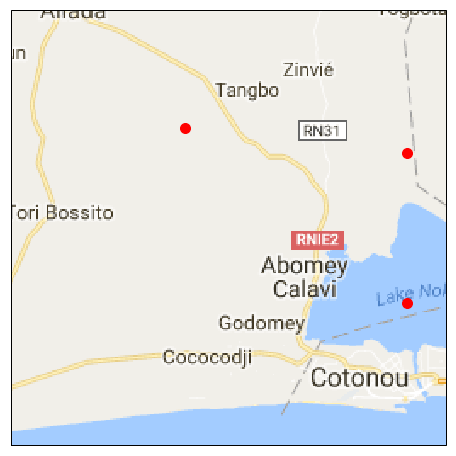

In [5]:
# first have a look at the points
osm_tiles = moa()
x, y = zip(*points_interest)

plt.figure(figsize=(8, 8))

# Use the tile's projection for the underlying map.
ax = plt.axes(projection=osm_tiles.crs)

# Specify a region of interest, in this case, Cardiff.
# ax.set_extent([1, 3, 6, 9],
#               ccrs.PlateCarree())

# Add the tiles at zoom level 10.
ax.add_image(osm_tiles, 10)
ax.plot(x, y, color='r', marker='.', markersize=20, linewidth=0., transform=ccrs.PlateCarree())
# ax.coastlines('10m')

plt.show()

In [6]:
# Uncheck for Wouter's files:
# os.path.abspath('../../githubdata/*.nc')
try:
    #    fns = glob.glob(r'os.path.abspath('../../githubdata/*.nc')') # Why does this path not work?    
#     fns_1 = glob.glob(r'C:\Users\908138\githubdata\37ghz_6km_H_A\NSIDC-0630-EASE2_T6.25km-AQUA-AMSRE-23H-A_2003.nc')
#     fns_2 = glob.glob(r'C:\Users\908138\githubdata\37ghz_6km_H_D\NSIDC-0630-EASE2_T6.25km-AQUA-AMSRE-23H-D_2003.nc')
    fns = glob.glob(r'C:\\Users\\908138\\githubdata\\37ghz_25km_H_A\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2002.nc')
    #    fns = glob.glob(r'C:\Users\908138\githubmain\NSIDC-AMSRE\netcdf\*.nc')
except:
    print('No data file found, please put check the following location: {:s}')

## Uncheck for Hessel's files:
# fns = glob.glob(r'd:\git\satellite-cookbook\NSIDC-AMSRE\netcdf\*.nc')

#fns = [fns_1, fns_2]
#fns.sort()
fns

['C:\\\\Users\\\\908138\\\\githubdata\\\\37ghz_25km_H_A\\\\NSIDC-0630-EASE2_T25km-AQUA-AMSRE-36H-A_2002.nc']

In [7]:
ts

NameError: name 'ts' is not defined

C:\ProgramData\Anaconda3\envs\benin_env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.
  after removing the cwd from sys.path.


Text(0.5,1,'Brightness temperatures at locations')

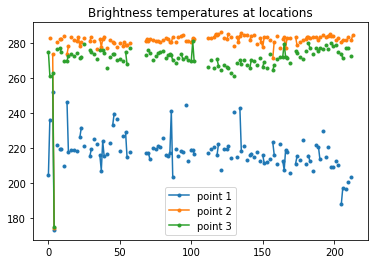

In [26]:
ds = xr.open_mfdataset(fns[0:5])
points_x, points_y = zip(*points_xy)

ts = ds.sel_points(x=list(points_x), y=list(points_y), method='nearest')
# From variable 'TB' let's plot time series sequentially
plt.figure()
values = ts['TB'].values
for n in range(len(ts['TB'])):
    #ax = plt.subplot(int('31{}'.format(n+1)))
    #ts['TB'][n].plot(ax=ax, marker='.', linewidth=0., label='point {:d}'.format(n + 1))
    plt.plot(values[n], marker='.', label='point {:d}'.format(n + 1))
plt.legend()
plt.title('Brightness temperatures at locations')
# list(points_x)
# ds.y

In [20]:
test = ts['TB'].values

In [10]:
ts['x']


<xarray.DataArray 'x' (points: 3)>
array([237739.97, 212714.71, 237739.97])
Coordinates:
    y        (points) float64 8.133e+05 8.383e+05 8.383e+05
    x        (points) float64 2.377e+05 2.127e+05 2.377e+05
Dimensions without coordinates: points
Attributes:
    standard_name:          projection_x_coordinate
    coverage_content_type:  coordinate
    long_name:              x
    units:                  meters
    axis:                   X
    valid_range:            [-17367530.44  17367530.44]

In [11]:
ts['y']

<xarray.DataArray 'y' (points: 3)>
array([813320.95, 838346.21, 838346.21])
Coordinates:
    y        (points) float64 8.133e+05 8.383e+05 8.383e+05
    x        (points) float64 2.377e+05 2.127e+05 2.377e+05
Dimensions without coordinates: points
Attributes:
    standard_name:          projection_y_coordinate
    coverage_content_type:  coordinate
    long_name:              y
    units:                  meters
    axis:                   Y
    valid_range:            [-6756820.2  6756820.2]

Prepare for the selected points of interest a time series. We will save these in a list of time series 's'. After that we interactively plot the data. You can select which point you are looking at, which date, which time window around that date. Alongside the plotted date, you will see (right-hand side) a plot of the brightness temperatures over the point of interest. To-Do: make the spatial window around the point displayed also configurable.

In [46]:
points_x[0]

234461.66100967856

In [34]:
ts['y'][0]

<xarray.DataArray 'y' ()>
array(813320.95)
Coordinates:
    y        float64 8.133e+05
    x        float64 2.377e+05
Attributes:
    standard_name:          projection_y_coordinate
    coverage_content_type:  coordinate
    long_name:              y
    units:                  meters
    axis:                   Y
    valid_range:            [-6756820.2  6756820.2]

In [50]:
s = [nsidc.c_m_ratio(ds['TB'], x, y)[2] for x, y in zip(points_x, points_y)]
#     s = [c_m_ratio(ds_win['TB'], x, y)[2] for ds_win, x, y in zip(window_ts, points_x, points_y)]
#ts = ds.sel_points(x=list(points_x), y=list(points_y), method='nearest')
#values = ts['TB'].values
px = list(points_x)
py = list(points_y)

def plot_func(idx, point, t_window, vmin, vmax):
    t = s[point].time.values[int(idx)]
    f = plt.figure(figsize=(12,6))
    ax1 = f.add_subplot(221)
    s[point].sel(time=slice(t- np.timedelta64(t_window, 'D'), t + np.timedelta64(t_window, 'D'))).plot(marker='.', linewidth=0.)
    plt.plot([t, t], ax1.get_ylim(), 'r')
    ax2 = f.add_subplot(222, projection=ccrs.PlateCarree())

    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    # get a mesh of the coordinates in grid's projection

    # now drape the data on the map
    p = ax2.pcolormesh(loni, lati, ds.sel(time=t)['TB'], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    # plot the current location in lat-lon
    p2 = plt.plot(*nsidc.proj_coord((s[point].x, s[point].y), proj_in, proj_out), marker='x', color='r')
    p3 = plt.plot(*nsidc.proj_coord((points_x[point], points_y[point]), proj_in, proj_out), marker='x', color='b')
    print(float(s[point].x), float(s[point].y))
    print(points_x[point], points_y[point])
    # also plot some points of interest 
    plt.colorbar(p, label='K')
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    
    ax3 = f.add_subplot(223)
    ax3.plot(values[point], marker='.', label='point {:d}'.format(point + 1))
    ax3.legend()
    # f.savefig
    
    ax4 = f.add_subplot(224, projection=ccrs.PlateCarree())

    ax4.add_feature(cfeature.LAND)
    ax4.add_feature(cfeature.OCEAN)
    # get a mesh of the coordinates in grid's projection

    # now drape the data on the map
    p = ax4.pcolormesh(loni, lati, ds.sel(time=t)['TB'], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    # plot the current location in lat-lon
    p2 = plt.plot(*nsidc.proj_coord((s[point].x, s[point].y), proj_in, proj_out), marker='x', color='r')
    # also plot some points of interest
    plt.colorbar(p, label='K')
    gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER

xi, yi = np.meshgrid(ds.x, ds.y)

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)

# below we interactively plot!
interact(plot_func,
         idx=(0., len(s[0]), 1.),
         point=range(len(s)),
         t_window=(10, 730, 1),
         vmin=(230, 290, 1),
         vmax=(250, 310, 1),
         continuous_update=False,
        )


interactive(children=(FloatSlider(value=107.0, description='idx', max=214.0, step=1.0), Dropdown(description='…

<function __main__.plot_func(idx, point, t_window, vmin, vmax)>

In [11]:
s = [nsidc.c_m_ratio(ds['TB'], x, y)[2] for x, y in zip(points_x, points_y)]
#     s = [c_m_ratio(ds_win['TB'], x, y)[2] for ds_win, x, y in zip(window_ts, points_x, points_y)]


def plot_func(idx, point, t_window, vmin, vmax):
    t = s[point].time.values[int(idx)]
    f = plt.figure(figsize=(12,6))
    ax1 = f.add_subplot(121)
    s[point].sel(time=slice(t- np.timedelta64(t_window, 'D'), t + np.timedelta64(t_window, 'D'))).plot(marker='.', linewidth=0.)
    plt.plot([t, t], ax1.get_ylim(), 'r')
    ax2 = f.add_subplot(122, projection=ccrs.PlateCarree())

    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    # get a mesh of the coordinates in grid's projection

    # now drape the data on the map
    p = ax2.pcolormesh(loni, lati, ds.sel(time=t)['TB'], transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    # plot the current location in lat-lon
    p2 = plt.plot(*nsidc.proj_coord((s[point].x, s[point].y), proj_in, proj_out), marker='x', color='r')
    # also plot some points of interest 
    plt.colorbar(p, label='K')
    gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    
#     ax3 = f.add_subplot(221)
    
    
    # f.savefig

xi, yi = np.meshgrid(ds.x, ds.y)

loni, lati = pyproj.transform(proj_in, proj_out, xi, yi)

# below we interactively plot!
interact(plot_func,
         idx=(0., len(s[0]), 1.),
         point=range(len(s)),
         t_window=(10, 730, 1),
         vmin=(230, 290, 1),
         vmax=(250, 310, 1),
         continuous_update=False,
        )


interactive(children=(FloatSlider(value=107.0, description='idx', max=214.0, step=1.0), Dropdown(description='…

<function __main__.plot_func(idx, point, t_window, vmin, vmax)>

In [9]:
# MOVING AVERAGE

# def moving_average(x,y,step_size=.1,bin_size=1):
#     bin_centers = np.arrange(np.min*x9)
# # ds.TB['MA_4'] = ds.TB.rolling(4).mean()



# ds['MA_4'] = ds.rolling(4).mean()

# ma = ds.rolling(window=5).mean()

# def plot_func(idx, point, t_window, vmin, vmax):
# def plot_func2(idx)
# df['MA'] = (ds.TB_time).rolling(window=4).mean()

Test

In [14]:
TB = ds.sel('TB')
TB.plot()

ValueError: the first argument to .sel must be a dictionary

In [12]:
ds #This is what the dataset looks like

<xarray.Dataset>
Dimensions:          (time: 214, x: 58, y: 76)
Coordinates:
  * y                (y) float64 1.889e+06 1.864e+06 1.839e+06 1.814e+06 ...
  * x                (x) float64 -4.63e+05 -4.379e+05 -4.129e+05 -3.879e+05 ...
  * time             (time) datetime64[ns] 2002-06-01 2002-06-02 2002-06-03 ...
Data variables:
    crs              (time) |S1 dask.array<shape=(214,), chunksize=(214,)>
    TB               (time, y, x) float32 dask.array<shape=(214, 76, 58), chunksize=(214, 76, 58)>
    TB_num_samples   (time, y, x) float32 dask.array<shape=(214, 76, 58), chunksize=(214, 76, 58)>
    TB_std_dev       (time, y, x) float32 dask.array<shape=(214, 76, 58), chunksize=(214, 76, 58)>
    Incidence_angle  (time, y, x) float32 dask.array<shape=(214, 76, 58), chunksize=(214, 76, 58)>
    TB_time          (time, y, x) float32 dask.array<shape=(214, 76, 58), chunksize=(214, 76, 58)>
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    title:                     MEaSUREs 

In [16]:
y

(6.43, 6.57, 6.55)

In [54]:
y

(6.43, 6.57, 6.55)